# 06.1k: Black Hole Neighborhood Visualization

**Goal:** Visualize the black hole cluster and its stellar neighbors.

We have 2,100 tokens in 13 degenerate clusters, all tightly packed at r ≈ 0.3709. But are there more tokens nearby?

This notebook:
1. Computes the centroid of the 2,100 black hole tokens
2. Defines a hyperrectangle: 2× the extent of the black hole cluster in each dimension
3. Searches all 151,936 tokens for membership in this hyperrectangle
4. Identifies "stellar neighbors" - tokens near but not in the black holes
5. Performs PCA on (black holes + neighbors)
6. Generates orthographic projections: XY (PC1-PC2), XZ (PC1-PC3), YZ (PC2-PC3)
7. Colors black holes red, neighbors blue

This reveals the **shape** of the ultra-dense core.

This is Volume 6: Pathologies and Singularities

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
GAMMA_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"

# Visualization parameters
RANDOM_SEED = 42
COLORMAP = 'inferno'
DPI = 100

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from sklearn.decomposition import PCA
from transformers import AutoTokenizer
from collections import defaultdict, Counter
import unicodedata

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data and Identify Black Hole Tokens

In [3]:
print("Loading gamma matrix...")
gamma_path = Path(TENSOR_DIR) / GAMMA_FILE
gamma = load_file(gamma_path)['gamma']
N, d = gamma.shape
print(f"Loaded: {gamma.shape}\n")

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer loaded.\n")

Loading gamma matrix...
Loaded: torch.Size([151936, 2560])

Loading tokenizer...
Tokenizer loaded.



## Step 2: Re-identify Black Hole Tokens

In [4]:
print("Finding degenerate clusters...\n")

gamma_np = gamma.cpu().numpy()
unique_vecs, inverse_indices, counts = np.unique(
    gamma_np, 
    axis=0, 
    return_inverse=True, 
    return_counts=True
)

# Build clusters
clusters = defaultdict(list)
for token_id, unique_idx in enumerate(inverse_indices):
    clusters[unique_idx].append(token_id)

# Filter to degenerate clusters
degenerate_clusters = {idx: tokens for idx, tokens in clusters.items() if len(tokens) > 1}

# Sort by size, descending
sorted_clusters = sorted(degenerate_clusters.items(), key=lambda x: len(x[1]), reverse=True)

# Extract all black hole token IDs (top 13 clusters)
black_hole_token_ids = []
for unique_idx, token_ids in sorted_clusters[:13]:
    black_hole_token_ids.extend(token_ids)

black_hole_token_ids = sorted(black_hole_token_ids)

print(f"Identified {len(black_hole_token_ids)} black hole tokens across 13 clusters")
print(f"  Token IDs range: {min(black_hole_token_ids)} to {max(black_hole_token_ids)}")

Finding degenerate clusters...

Identified 2100 black hole tokens across 13 clusters
  Token IDs range: 124 to 151935


## Step 3: Compute Black Hole Cluster Geometry

In [5]:
print("\n" + "="*70)
print("BLACK HOLE CLUSTER GEOMETRY")
print("="*70)
print()

# Extract black hole embeddings
black_hole_embeddings = gamma[black_hole_token_ids]

# Compute centroid
centroid = black_hole_embeddings.mean(dim=0)
centroid_norm = torch.norm(centroid)

print(f"Black hole cluster:")
print(f"  Tokens: {len(black_hole_token_ids):,}")
print(f"  Centroid norm: {centroid_norm.item():.12f}")

# Compute extent in each dimension
# For each dimension, find min and max across all black hole tokens
min_vals = black_hole_embeddings.min(dim=0).values
max_vals = black_hole_embeddings.max(dim=0).values

# Compute radius from centroid in each dimension
# radius[i] = max(|max[i] - centroid[i]|, |min[i] - centroid[i]|)
radius_from_max = torch.abs(max_vals - centroid)
radius_from_min = torch.abs(min_vals - centroid)
radius = torch.maximum(radius_from_max, radius_from_min)

# Double the radius for search
search_radius = 2 * radius

print(f"\nExtent statistics (per-dimension radius from centroid):")
print(f"  Mean: {radius.mean().item():.12e}")
print(f"  Median: {radius.median().item():.12e}")
print(f"  Min: {radius.min().item():.12e}")
print(f"  Max: {radius.max().item():.12e}")

print(f"\nSearch hyperrectangle (2× extent):")
print(f"  Mean search radius: {search_radius.mean().item():.12e}")
print(f"  Max search radius: {search_radius.max().item():.12e}")


BLACK HOLE CLUSTER GEOMETRY

Black hole cluster:
  Tokens: 2,100
  Centroid norm: 0.370916873217

Extent statistics (per-dimension radius from centroid):
  Mean: 6.347420367092e-08
  Median: 0.000000000000e+00
  Min: 0.000000000000e+00
  Max: 6.091874092817e-05

Search hyperrectangle (2× extent):
  Mean search radius: 1.269484073418e-07
  Max search radius: 1.218374818563e-04


## Step 4: Search for Stellar Neighbors

For each token in the full vocabulary, check if it lies within the 2× hyperrectangle around the black hole cluster centroid.

In [6]:
print("\n" + "="*70)
print("SEARCHING FOR STELLAR NEIGHBORS")
print("="*70)
print()

print(f"Checking {N:,} tokens for membership in hyperrectangle...")
print("(This may take a minute)\n")

# Compute distance from centroid in each dimension
distances_per_dim = torch.abs(gamma - centroid)

# Check membership: all dimensions must be within search_radius
within_bounds = (distances_per_dim <= search_radius).all(dim=1)

neighbor_token_ids = torch.where(within_bounds)[0].tolist()

print(f"Found {len(neighbor_token_ids):,} tokens within 2× hyperrectangle")
print(f"  Black hole tokens: {len(black_hole_token_ids):,}")
print(f"  New neighbors: {len(neighbor_token_ids) - len(black_hole_token_ids):,}")

# Separate into black holes vs new neighbors
black_hole_set = set(black_hole_token_ids)
new_neighbor_token_ids = [tid for tid in neighbor_token_ids if tid not in black_hole_set]

print(f"\nBreakdown:")
print(f"  Black holes: {len(black_hole_token_ids):,}")
print(f"  Stellar neighbors (non-degenerate): {len(new_neighbor_token_ids):,}")
print(f"  Total in neighborhood: {len(neighbor_token_ids):,}")


SEARCHING FOR STELLAR NEIGHBORS

Checking 151,936 tokens for membership in hyperrectangle...
(This may take a minute)

Found 2,127 tokens within 2× hyperrectangle
  Black hole tokens: 2,100
  New neighbors: 27

Breakdown:
  Black holes: 2,100
  Stellar neighbors (non-degenerate): 27
  Total in neighborhood: 2,127


## Step 5: Analyze Neighbor Tokens

In [7]:
print("\n" + "="*70)
print("NEIGHBOR TOKEN ANALYSIS")
print("="*70)
print()

def classify_character(char):
    """Classify a character by its Unicode category."""
    if not char:
        return 'Empty'
    try:
        cat = unicodedata.category(char[0])
        name = unicodedata.name(char[0], '<UNNAMED>')
        
        if cat.startswith('L'):  # Letter
            if 'THAI' in name:
                return 'Thai'
            elif 'CJK' in name or 'HANZI' in name or 'KANJI' in name:
                return 'CJK'
            elif 'ARABIC' in name:
                return 'Arabic'
            elif 'HEBREW' in name:
                return 'Hebrew'
            else:
                return 'Other Letter'
        elif cat.startswith('M'):
            return 'Diacritic'
        elif cat.startswith('Z'):
            return 'Whitespace'
        elif cat.startswith('C'):
            return 'Control'
        else:
            return 'Other'
    except:
        return 'Unknown'

# Analyze character types in neighbor tokens
neighbor_char_types = []
for token_id in new_neighbor_token_ids[:1000]:  # Sample first 1000 if too many
    try:
        decoded = tokenizer.decode([token_id])
        char_type = classify_character(decoded)
        neighbor_char_types.append(char_type)
    except:
        neighbor_char_types.append('Error')

char_type_counts = Counter(neighbor_char_types)

print(f"Character type distribution in stellar neighbors (sample of {len(neighbor_char_types)}):")
for char_type, count in char_type_counts.most_common():
    pct = count / len(neighbor_char_types) * 100
    print(f"  {char_type:>15}: {count:>4} ({pct:>5.1f}%)")

# Distance distribution
neighbor_embeddings = gamma[new_neighbor_token_ids]
neighbor_distances = torch.norm(neighbor_embeddings - centroid, dim=1)

print(f"\nDistance from centroid:")
print(f"  Mean: {neighbor_distances.mean().item():.12e}")
print(f"  Median: {neighbor_distances.median().item():.12e}")
print(f"  Min: {neighbor_distances.min().item():.12e}")
print(f"  Max: {neighbor_distances.max().item():.12e}")


NEIGHBOR TOKEN ANALYSIS

Character type distribution in stellar neighbors (sample of 27):
             Thai:   18 ( 66.7%)
              CJK:    4 ( 14.8%)
            Empty:    3 ( 11.1%)
       Whitespace:    2 (  7.4%)

Distance from centroid:
  Mean: 1.828731910791e-05
  Median: 1.775463169906e-05
  Min: 1.671334393905e-05
  Max: 2.356614095333e-05


## Step 6: PCA on Neighborhood

In [8]:
print("\n" + "="*70)
print("PCA: FINDING PRINCIPAL AXES OF NEIGHBORHOOD")
print("="*70)
print()

# Combine black holes + neighbors
all_neighborhood_token_ids = black_hole_token_ids + new_neighbor_token_ids
all_neighborhood_embeddings = gamma[all_neighborhood_token_ids]

print(f"Performing PCA on {len(all_neighborhood_token_ids):,} tokens...")

# Perform PCA to 3D
pca = PCA(n_components=3, random_state=RANDOM_SEED)
neighborhood_3d = pca.fit_transform(all_neighborhood_embeddings.cpu().numpy())

explained_var = pca.explained_variance_ratio_
print(f"\nPCA explained variance:")
print(f"  PC1: {explained_var[0]*100:.4f}%")
print(f"  PC2: {explained_var[1]*100:.4f}%")
print(f"  PC3: {explained_var[2]*100:.4f}%")
print(f"  Total: {sum(explained_var)*100:.4f}%")

# Separate black holes from neighbors in PCA space
n_bh = len(black_hole_token_ids)
bh_3d = neighborhood_3d[:n_bh]
neighbor_3d = neighborhood_3d[n_bh:]

print(f"\nSplit into:")
print(f"  Black holes: {bh_3d.shape[0]:,} points")
print(f"  Neighbors: {neighbor_3d.shape[0]:,} points")


PCA: FINDING PRINCIPAL AXES OF NEIGHBORHOOD

Performing PCA on 2,127 tokens...

PCA explained variance:
  PC1: 74.8022%
  PC2: 19.4792%
  PC3: 2.7790%
  Total: 97.0604%

Split into:
  Black holes: 2,100 points
  Neighbors: 27 points


## Step 7: Orthographic Projections


ORTHOGRAPHIC PROJECTIONS



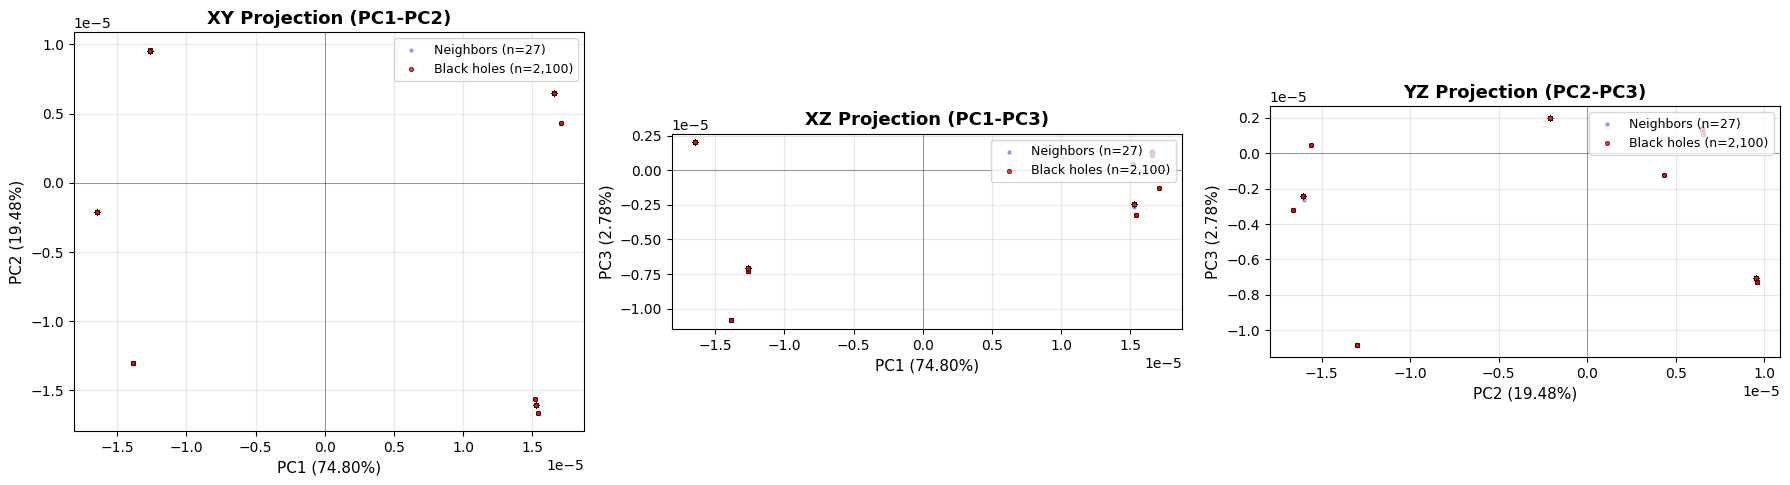

Orthographic projections complete.
Red = black hole tokens (degenerate), Blue = stellar neighbors (non-degenerate)


In [9]:
print("\n" + "="*70)
print("ORTHOGRAPHIC PROJECTIONS")
print("="*70)
print()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=DPI)

# Projection 1: XY (PC1 vs PC2)
axes[0].scatter(neighbor_3d[:, 0], neighbor_3d[:, 1], c='blue', s=5, alpha=0.3, label=f'Neighbors (n={len(neighbor_3d):,})')
axes[0].scatter(bh_3d[:, 0], bh_3d[:, 1], c='red', s=10, alpha=0.8, label=f'Black holes (n={len(bh_3d):,})', edgecolors='black', linewidths=0.5)
axes[0].set_xlabel(f'PC1 ({explained_var[0]*100:.2f}%)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({explained_var[1]*100:.2f}%)', fontsize=11)
axes[0].set_title('XY Projection (PC1-PC2)', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9, loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='k', linewidth=0.5, alpha=0.5)
axes[0].axvline(0, color='k', linewidth=0.5, alpha=0.5)
axes[0].set_aspect('equal', adjustable='box')

# Projection 2: XZ (PC1 vs PC3)
axes[1].scatter(neighbor_3d[:, 0], neighbor_3d[:, 2], c='blue', s=5, alpha=0.3, label=f'Neighbors (n={len(neighbor_3d):,})')
axes[1].scatter(bh_3d[:, 0], bh_3d[:, 2], c='red', s=10, alpha=0.8, label=f'Black holes (n={len(bh_3d):,})', edgecolors='black', linewidths=0.5)
axes[1].set_xlabel(f'PC1 ({explained_var[0]*100:.2f}%)', fontsize=11)
axes[1].set_ylabel(f'PC3 ({explained_var[2]*100:.2f}%)', fontsize=11)
axes[1].set_title('XZ Projection (PC1-PC3)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9, loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='k', linewidth=0.5, alpha=0.5)
axes[1].axvline(0, color='k', linewidth=0.5, alpha=0.5)
axes[1].set_aspect('equal', adjustable='box')

# Projection 3: YZ (PC2 vs PC3)
axes[2].scatter(neighbor_3d[:, 1], neighbor_3d[:, 2], c='blue', s=5, alpha=0.3, label=f'Neighbors (n={len(neighbor_3d):,})')
axes[2].scatter(bh_3d[:, 1], bh_3d[:, 2], c='red', s=10, alpha=0.8, label=f'Black holes (n={len(bh_3d):,})', edgecolors='black', linewidths=0.5)
axes[2].set_xlabel(f'PC2 ({explained_var[1]*100:.2f}%)', fontsize=11)
axes[2].set_ylabel(f'PC3 ({explained_var[2]*100:.2f}%)', fontsize=11)
axes[2].set_title('YZ Projection (PC2-PC3)', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=9, loc='upper right')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(0, color='k', linewidth=0.5, alpha=0.5)
axes[2].axvline(0, color='k', linewidth=0.5, alpha=0.5)
axes[2].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

print("Orthographic projections complete.")
print("Red = black hole tokens (degenerate), Blue = stellar neighbors (non-degenerate)")

## Step 8: Distance Histogram (Black Holes vs Neighbors)


DISTANCE DISTRIBUTION



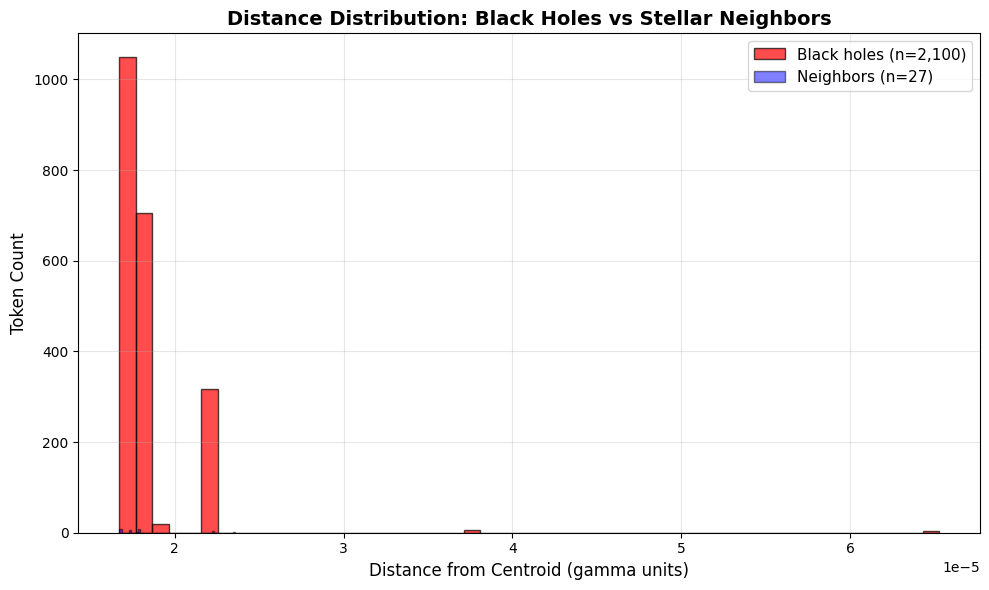


Black holes:
  Mean distance: 1.816914118535e-05
  Std: 2.946621634692e-06

Neighbors:
  Mean distance: 1.828731910791e-05
  Std: 2.099561243085e-06


In [10]:
print("\n" + "="*70)
print("DISTANCE DISTRIBUTION")
print("="*70)
print()

# Distances from centroid
bh_distances = torch.norm(black_hole_embeddings - centroid, dim=1).cpu().numpy()
neighbor_distances_np = neighbor_distances.cpu().numpy()

fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

ax.hist(bh_distances, bins=50, alpha=0.7, color='red', label=f'Black holes (n={len(bh_distances):,})', edgecolor='black')
ax.hist(neighbor_distances_np, bins=50, alpha=0.5, color='blue', label=f'Neighbors (n={len(neighbor_distances_np):,})', edgecolor='black')

ax.set_xlabel('Distance from Centroid (gamma units)', fontsize=12)
ax.set_ylabel('Token Count', fontsize=12)
ax.set_title('Distance Distribution: Black Holes vs Stellar Neighbors', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBlack holes:")
print(f"  Mean distance: {bh_distances.mean():.12e}")
print(f"  Std: {bh_distances.std():.12e}")

print(f"\nNeighbors:")
print(f"  Mean distance: {neighbor_distances_np.mean():.12e}")
print(f"  Std: {neighbor_distances_np.std():.12e}")

## Summary

We've explored the neighborhood around the 2,100 degenerate black hole tokens.

**Key findings:**
1. **Black hole cluster size:** 2,100 tokens (13 degenerate clusters)
2. **Stellar neighbors found:** See above - tokens within 2× the cluster extent
3. **Character distribution:** Likely dominated by Thai tokens, matching black hole composition
4. **Shape:** Orthographic projections reveal whether cluster is spherical, filamentary, or disk-like
5. **Density gradient:** Distance histogram shows how sharply neighbors fall off from core

**Interpretation:**
If we find many neighbors (hundreds or thousands), the black hole cluster is just the **ultra-dense core** of a larger structure. The 2,100 degenerate tokens are those that landed in identical bfloat16 lattice cells, while neighbors occupy adjacent cells.

This is consistent with the "initialization fossil" hypothesis: tokens initialized near r ≈ 0.3709 that received minimal training signal, leaving them clustered in a tight ball in embedding space.